In [1]:
import gym
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
import torch
from torch import nn

from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from rl_zoo3.wrappers import FrameSkip

In [18]:
env_name = 'MountainCarContinuous-v0'

# MountainCarContinuous SB3 A2C baseline

Let's establish a baseline using sb3 and rl_zoo3 libraries. We will be using frameskip wrapper from rl_zoo3. This environment needs it to enable stable convergence.

In [10]:
env = make_vec_env(env_name, 
                   n_envs=8, 
                   wrapper_class=FrameSkip)

In [11]:
model = A2C("MlpPolicy", env, verbose=1, 
            n_steps=30,
            ent_coef=0.0001)

Using cpu device


In [12]:
model.learn(total_timesteps=1e6)

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 680      |
|    ep_rew_mean        | 40.3     |
| time/                 |          |
|    fps                | 10187    |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 24000    |
| train/                |          |
|    entropy_loss       | -1.4     |
|    explained_variance | 0.0118   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.336    |
|    std                | 0.979    |
|    value_loss         | 317      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 669      |
|    ep_rew_mean        | 18.4     |
| time/                 |          |
|    fps                | 10224    |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 48000    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 362      |
|    ep_rew_mean        | 70.2     |
| time/                 |          |
|    fps                | 10193    |
|    iterations         | 1400     |
|    time_elapsed       | 32       |
|    total_timesteps    | 336000   |
| train/                |          |
|    entropy_loss       | -1.42    |
|    explained_variance | 0.0151   |
|    learning_rate      | 0.0007   |
|    n_updates          | 1399     |
|    policy_loss        | 19.2     |
|    std                | 0.997    |
|    value_loss         | 1.31e+03 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 335      |
|    ep_rew_mean        | 76.4     |
| time/                 |          |
|    fps                | 10193    |
|    iterations         | 1500     |
|    time_elapsed       | 35       |
|    total_timesteps    | 360000   |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 149      |
|    ep_rew_mean        | 90       |
| time/                 |          |
|    fps                | 10193    |
|    iterations         | 2700     |
|    time_elapsed       | 63       |
|    total_timesteps    | 648000   |
| train/                |          |
|    entropy_loss       | -1.36    |
|    explained_variance | 8.25e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 2699     |
|    policy_loss        | 0.152    |
|    std                | 0.949    |
|    value_loss         | 359      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | 90.7     |
| time/                 |          |
|    fps                | 10192    |
|    iterations         | 2800     |
|    time_elapsed       | 65       |
|    total_timesteps    | 672000   |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 85.5     |
|    ep_rew_mean        | 92.7     |
| time/                 |          |
|    fps                | 10142    |
|    iterations         | 4000     |
|    time_elapsed       | 94       |
|    total_timesteps    | 960000   |
| train/                |          |
|    entropy_loss       | -1.24    |
|    explained_variance | 0.452    |
|    learning_rate      | 0.0007   |
|    n_updates          | 3999     |
|    policy_loss        | 1.36     |
|    std                | 0.832    |
|    value_loss         | 40.4     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 84.6     |
|    ep_rew_mean        | 92.6     |
| time/                 |          |
|    fps                | 10135    |
|    iterations         | 4100     |
|    time_elapsed       | 97       |
|    total_timesteps    | 984000   |
|

In [13]:
test_env = make_vec_env(env_name, n_envs=1)

In [19]:
def eval_agent(env, actor, n_steps=1000, render=True):
    state = env.reset()

    rewards, logits = [], []
    for _ in range(n_steps):
        if render:
            env.render()

        action = actor.predict(state)
        next_state, reward, done, info = env.step(action[0])

        rewards.append(reward)

        state = next_state
        if done:
            break

    env.close()
    return sum(rewards)

In [20]:
eval_agent(test_env, model, n_steps=1000, render=True)

array([93.09493], dtype=float32)

The model converges to rewards around 90 within 1e6 steps. Let's now try to repeat the result using DIY functionality.

# DIY A2C on MountainCarContinuous-v0 with frameskip

In [21]:
env = gym.make(env_name)
envs = make_vec_env(env_name, n_envs=8, 
                   wrapper_class=FrameSkip)#batch_agent_not_mc(env_name=env_name, n_envs=3)

init_observation = env.reset()
state_len = len(env.reset())
action_len = len(env.action_space.sample())

DISCOUNT = 0.99

In [22]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = len(envs.action_space.sample())

In [23]:
class Actor(torch.nn.Module):
    
    def __init__(self, obs_len=state_len, action_len=action_len):
        super().__init__()
        self.obs_len = obs_len
        self.action_len = action_len
        
        self.lin_1 = torch.nn.Linear(self.obs_len, 256)
        self.rel_1 = torch.nn.ReLU()

        self.lin_2 = torch.nn.Linear(256, self.action_len)
        
        self.lin_3 = torch.nn.Linear(256, self.action_len)
        self.elu = torch.nn.ELU()
        
        
    def forward(self, x):
        x = self.lin_1(x)
        x = self.rel_1(x)

        mu = self.lin_2(x)
        
        x = self.lin_3(x)
        sigma = self.elu(x) + 1.000001
        
        return mu, sigma
    
    def act(self, observation):
        (mu, sigma) = self.forward(observation)
        dist = torch.distributions.normal.Normal(mu, sigma)
        action = dist.sample()
        logit = dist.log_prob(action)   
        entropy = dist.entropy()
        return action, logit, entropy
    

class Critic(torch.nn.Module):
    
    def __init__(self, obs_len=state_len):
        super().__init__()
        self.obs_len = obs_len
        self.lin_1 = torch.nn.Linear(self.obs_len, 256)
        self.rel_1 = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(p=0.15)
        self.lin_2 = torch.nn.Linear(256, 1)
    
    def forward(self, x):
        x = self.lin_1(x)
        x = self.rel_1(x)
        x = self.drop(x)
        x = self.lin_2(x)
        return x

In [40]:
def eval_agent(actor, n_steps=300, render=True):
    state = env.reset()

    rewards, logits = [], []
    for _ in range(n_steps):
        if render:
            env.render()

        action, _, _ = actor.act(torch.tensor(state, dtype=torch.float32))
        next_state, reward, done, info = env.step([action.detach().numpy()[0]])

        rewards.append(reward)

        state = next_state
        if done:
            break

    env.close()
    return sum(rewards)

def calc_cum_rewards(next_state_vals, rewards, dones, discount=DISCOUNT):
    res = []
    G = next_state_vals.T
    for done, el in zip(dones.flip(0), rewards.flip(0)):
        G = el + discount * G * done
        res.insert(0, G)
    return torch.stack(res).squeeze()

def calc_losses(rewards, state_values, next_state_value, logits, entropies, dones, DISCOUNT):
    rewards = torch.tensor(rewards, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).squeeze()

    cum_rewards = calc_cum_rewards(next_state_value, rewards, dones, discount=DISCOUNT)
    stacked_state_values = torch.stack(state_values).squeeze()
    stacked_logits = torch.stack(logits).squeeze()

    entropy = torch.stack(entropies).sum()

    advantage = (cum_rewards - stacked_state_values).detach()
    actor_loss =  - (stacked_logits * advantage).mean() - 0.0001 * entropy.mean()
    critic_loss = torch.nn.functional.mse_loss(cum_rewards, 
                                               stacked_state_values)
    return actor_loss, critic_loss

def learn_one_traj(actor, critic, actor_opt, critic_opt, 
               traj_length=20, n_steps=200, discount=DISCOUNT):
    state =  envs.reset()
    states, rewards, logits, state_values, entropies, \
    next_state_values, dones, actor_losses, critic_losses = [], [], [], [], [], [], [], [], []
    for step in range(n_steps):

        #we get the action from the actor
        action, logit, entropy = actor.act(torch.tensor(state, dtype=torch.float32))

        #use the action to make a step by the env
        next_state, reward, done, info = envs.step(action) #.detach().numpy()
        
        # getting state and next state values from critic
        state_value = critic(torch.tensor(state, dtype=torch.float32))
        next_state_value = critic(torch.tensor(next_state, dtype=torch.float32))

        entropies.append(entropy)
        rewards.append(reward)
        logits.append(logit)
        state_values.append(state_value)
        next_state_values.append(next_state_value)

        dones.append(1 - np.array(done))

        state = next_state

        # calculate losses if we made enough steps for 1 trajectory
        if (step % traj_length == 0) and step > 1:
            if len(next_state_value.shape) < 2: next_state_value = next_state_value.unsqueeze(0)
            actor_loss, critic_loss = calc_losses(rewards[-traj_length:], 
                                                  state_values[-traj_length:], 
                                                  next_state_value, 
                                                  logits[-traj_length:],
                                                  entropies[-traj_length:],
                                                  dones[-traj_length:],
                                                  discount)
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)

            actor_opt.zero_grad()
            actor_loss.backward()
            actor_opt.step()

            critic_opt.zero_grad()
            critic_loss.backward()
            critic_opt.step()

    out = (states, rewards, logits, state_values, next_state_values, dones, 
           actor_losses, critic_losses, entropies)
    return out

In [43]:
actor = Actor()
critic = Critic()
lr = 7e-4
actor_opt = torch.optim.Adam(actor.parameters(),   lr=lr)
critic_opt = torch.optim.Adam(critic.parameters(), lr=lr)

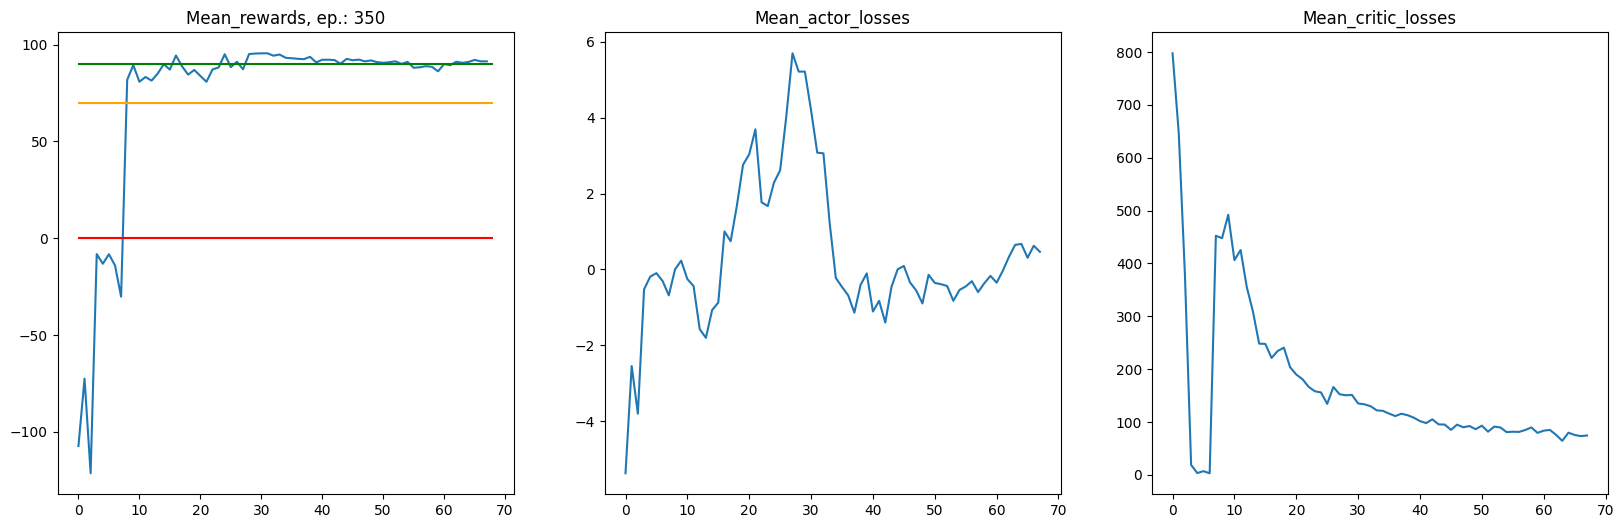

KeyboardInterrupt: 

In [47]:
mean_rewards, all_actor_losses, all_critic_losses, mean_critic_losses, mean_actor_losses = \
    [], [], [], [], []

for ep in range(int(2e3)): #
    states, rewards, logits, state_values, next_state_values, dones, actor_losses, critic_losses, entropies = \
            learn_one_traj(actor, critic, actor_opt, critic_opt, traj_length=50, n_steps=500)
    
    
    ################## progress plotting ##################
    all_actor_losses.append(torch.stack(actor_losses).median().detach().numpy())
    all_critic_losses.append(torch.stack(critic_losses).median().detach().numpy())
    
    ave_over=10
    if ep%ave_over==0:
        mean_critic_losses.append(np.median(all_critic_losses[-ave_over:]))
        mean_actor_losses.append(np.median(all_actor_losses[-ave_over:]))
        mean_rewards.append(np.median([eval_agent(actor, n_steps=1000, render=False) for _ in range(30)]))
        
        clear_output()
        fig, ax = plt.subplots(1, 3, figsize=(20, 6))
        ax[0].plot(mean_rewards); ax[0].set_title(f'Mean_rewards, ep.: {ep}')
        ax[0].hlines(0, 0, len(mean_rewards), color='red')
        ax[0].hlines(70, 0, len(mean_rewards), color='orange')
        ax[0].hlines(90, 0, len(mean_rewards), color='green')
        
        ax[1].plot(mean_actor_losses); ax[1].set_title('Mean_actor_losses')
        ax[2].plot(mean_critic_losses); ax[2].set_title('Mean_critic_losses')
        plt.show()

The agent repeats the baseline results.

In [51]:
test_res = [eval_agent(actor, n_steps=1000, render=False) for _ in range(1000)]
med = np.median(test_res)
std = np.std(test_res)

In [52]:
med

90.98183966439393

In [53]:
std

3.323945755031544